## Introduction
This notebook implements a solution for the Kaggle Planet: [Understanding the Amazon from Space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space) challenge by finetunning a ResNet50 previously trained in ImageNet. 

Sections and code are ordered in a way that should be easy to follow, if you have doubts or comments please do not hesitate in reaching me by opening an issue in my ml-journey repository: https://github.com/lddm/ml-journey  

I use this notebook for both training and applying the classifier for the challenge. The latest state of the notebook in github may not have all cells' outputs. If you have doubts about some output you can always try running the notebook end-to-end on your own or ask me, I would be happy to help.

With the latest classifier trained in this notebook a score of `0.89188` was obtained, the top score in the challenge leaderboard is `0.93317`. Although the score is not yet at the same level as the top scores, I believe the obtained classifier is sufficiently good for the application of forest monitoring I plan to work on next. I may get back to work on improving this classifier in the future, in that case, I believe the following points are worth reviewing:
* The neural network may be overfitting the training data and may benefit from including a weight-decay in the loss while training.
* I'm using Colab free infrastructure for training and classification. Currently training is somewhat limited by the interaction of GPU speed and memory and the timeout Google set when using the Colab free environment. There's some potential benefit of using TPUs instead. To the best of my knowledge, the easiest way to make the switch would be to move from using PyTorch to Pytorch-Lighting. PyTorch-Lighting provides a lot of extra benefits and was recommended by several colleagues and friends, I definitely want to try it out in the future

# Environment setup

In [1]:
# To change Jupyter notebook to a dark theme the following command can be issued in a terminal before launching
# jupyter notebook server
! jt -t onedork -fs 95 -altp -tfs 11 -nfs 115 -cellw 88% -T


In [1]:
%matplotlib inline

# Imports
import os
import time
import copy
import torch
import torchvision
import cv2

import pandas as pd
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import telluric as tl

from PIL import Image
from tqdm import tqdm

from sklearn.preprocessing import MultiLabelBinarizer
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split

from utils import preprocess_raster_image

# Constants
TRAIN_DIR = 'train/train-jpg'
TEST_DIR = 'test/test-jpg'
# ROOT_PATH = '/content/gdrive/MyDrive/planet_amazon'
ROOT_PATH = '.'
MODEL_PATH = os.path.join(ROOT_PATH, 'planet_challenge_model_one_cycle_lr_v2.tar')
TRAINING_BATCH_SIZE = 64
VALIDATION_BATCH_SIZE = 64
TRAINING_EPOCHS = 5
SUBMISSION_FILENAME = 'submission_one_cycle_lr_data_augmentation.csv'
CLR_PICKLE_PATH = 'clr_test.bin'

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Auxiliary functions

In [3]:
def get_items(df):
    return df
    # Grab subset of items
    # return df.sample(n=64*30, random_state=891237)

def get_x(df_row):
    img_name = df_row['image_name']
    img_path = os.path.join(TRAIN_DIR, f'{img_name}.jpg')
    return img_path

def get_y(df_row):
    return df_row['tags'].split(' ')

def imshow(inp, fig_size=4, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    ax.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def initialize_resnet(num_classes, use_pretrained=True):
    model = models.resnet50(pretrained=use_pretrained)
    # Adjust last fully connected layer to number of classes in the PlanetAmazonChallenge
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# Based on https://www.kaggle.com/igormq/f-beta-score-for-pytorch
def f2_score(y_true, y_pred, threshold=0.5):
    return fbeta_score(y_true, y_pred, 2, threshold)


def fbeta_score(y_true, y_pred, beta, threshold, eps=1e-9):
    beta2 = beta**2

    y_pred = torch.ge(y_pred.float(), threshold).float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum(dim=1)
    precision = true_positive.div(y_pred.sum(dim=1).add(eps))
    recall = true_positive.div(y_true.sum(dim=1).add(eps))

    return torch.mean(
        (precision*recall).
        div(precision.mul(beta2) + recall + eps).
        mul(1 + beta2))

# Based on https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
# Allows obtaining image paths when iterating by batches using the DataLoader
# Code is modified to only return the file name, without path and without 
# extension, thus generating the output format expected by the Kaggle 
# competition
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        img_path = self.imgs[index][0]
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (img_name,))
        return tuple_with_path

The [torchvision.datasets](https://pytorch.org/vision/0.8/datasets.html#torchvision-datasets) class expects a specific structure for the data and their corresponding labels, e.g: 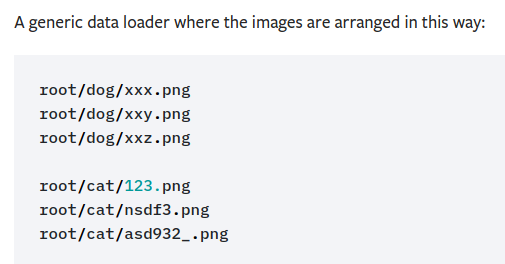

This is not very convenient for handling how data is provided in the Kaggle _Understanding the Amazon from Space_ challenge. This is easily fixable by implementing a custom sub-class of the torch Dataset class. Code below is based on https://www.kaggle.com/mratsim/starting-kit-for-pytorch-deep-learning#Loading-the-data---first-part---DataSet  

The implemented `KaggleAmazonDataset` makes use of [sklearn.preprocessing.MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html#sklearn-preprocessing-multilabelbinarizer) to encode the categorical labels in a convenient numerical format for the training.

In [8]:
class KaggleAmazonDataset(Dataset):
    """Dataset wrapping images and target labels for Kaggle - Planet Amazon from Space competition.

    Arguments:
        A CSV file path
        Path to image folder
        Extension of images
        Transform (optional) object containing transformations to apply on imagery.
    """

    def __init__(self, csv_path, img_path, img_ext, transform=None, number_samples=None, check_corrupt_files=True):
    
        self.tmp_df = pd.read_csv(csv_path)
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform
        
        if check_corrupt_files:
            self._check_corrupt_files()

        image_names = self.tmp_df['image_name']
        tags = self.tmp_df['tags']
        if number_samples:
          image_names = image_names[:number_samples]
          tags = tags[:number_samples]
          self.dataset_size = number_samples
        else:
          self.dataset_size = len(image_names)

        self.X_train = image_names
        # self.y_train is a sparse-matrix of size num_samples x num_classes where an element [i,j] equals 1 
        # iff the sample with index 'i' correspond to class 'j'
        self.y_train = self.mlb.fit_transform(tags.str.split()).astype(np.float32)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.X_train[index] + 
                                      self.img_ext))
        img = img.convert('RGB')
        if self.transform is not None:
          img = self.transform(img)

        label = torch.from_numpy(self.y_train[index])
        return img, label
    
    def _check_corrupt_files(self):
        # check that all images listed in the train.csv are available on the training folder
        assert self.tmp_df['image_name'].apply(lambda x: os.path.isfile(os.path.join(
                self.img_path, x + self.img_ext))).all(), \
"Some images referenced in the CSV file were not found"
        
        # some files available in the folder are corrupted causing an PIL.UnidentifiedImageError
        for image_name in self.tmp_df['image_name']:
          file_size = os.stat(os.path.join(
              self.img_path, image_name + self.img_ext)).st_size
          if file_size == 0:
            raise(OSError('File {} is corrupt'.format(image_name)))
        
    
    def decode_binary_label(self, array):
      return self.mlb.inverse_transform(array)

    def __len__(self):
        return len(self.X_train.index)

## Load dataset and split it into training and validation sub-sets

In [5]:
# the parameters used here are based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_transforms = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      # Normalization mean and std. dev. 
                                      # factors are taken from ImageNet
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])])

dataset = KaggleAmazonDataset('train_v2.csv', TRAIN_DIR, '.jpg', 
                                    data_transforms, check_corrupt_files=False)

dataset_validation_ratio = 0.2
dataset_validation_size = int(dataset_validation_ratio * len(dataset))
dataset_train_size = len(dataset) - dataset_validation_size
dataset_train, dataset_valid = random_split(dataset, (dataset_train_size, dataset_validation_size))

train_loader = DataLoader(dataset_train,
                          batch_size=TRAINING_BATCH_SIZE,
                          shuffle=True,
                          num_workers=1, # 1 for CUDA
                          pin_memory=True # CUDA only
                         )

val_loader = DataLoader(dataset_valid,
                        batch_size=VALIDATION_BATCH_SIZE,
                        shuffle=False,
                        num_workers=1, # 1 for CUDA
                        pin_memory=True # CUDA only
                        )

dataloaders = {
    'train': train_loader,
    'val': val_loader
}


dataset_sizes = {'train': len(dataset_train),
                 'val': len(dataset_valid)}

In [6]:
dataset_sizes

{'train': 32384, 'val': 8095}

## Test train_loader and classes decoding

In [7]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

imshow(out, fig_size=20)

train_dataset.decode_binary_label(classes)

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/lddm/Development/forests-monitoring/.venv_37_classification/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/lddm/Development/forests-monitoring/.venv_37_classification/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/lddm/Development/forests-monitoring/.venv_37_classification/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/lddm/Development/forests-monitoring/.venv_37_classification/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 330, in __getitem__
    return self.dataset[self.indices[idx]]
  File "<ipython-input-4-64beaf433caa>", line 39, in __getitem__
    self.img_ext))
  File "/home/lddm/Development/forests-monitoring/.venv_37_classification/lib/python3.7/site-packages/PIL/Image.py", line 2912, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: 'train/train-jpg/train_34012.jpg'


## Finetunning the network

In [ ]:
def train_model(model, criterion, optimizer, scheduler, one_cycle=None, 
                last_epoch=0, num_epochs=25, save_model=False, threshold=0, 
                epoch_loss_evolution={}, epoch_acc_evolution=[]):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    if epoch_acc_evolution:
      best_acc = max(epoch_acc_evolution)
    else:
      best_acc = 0.0
    
    for epoch in range(last_epoch, num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            with tqdm(dataloaders[phase], unit="batch", 
                      desc='Epoch {}/{}'.format(epoch, num_epochs - 1)) as training_batch:
              for inputs, labels in training_batch:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  if phase == 'train' and one_cycle:
                    lr, mom = one_cycle.calc()
                    update_lr(optimizer, lr)
                    update_mom(optimizer, mom)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      preds = outputs > threshold
                      loss = criterion(outputs, labels)

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)

                # print('f2beta score: ', fbeta_score(labels.data, preds, 2, 0.2))
            if phase == 'train' and one_cycle is None:
                scheduler.step()

            epoch_loss_evolution[phase].append(running_loss 
                                               / dataset_sizes[phase])
            
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc_evolution.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss_evolution[phase][-1], epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if save_model:
                  torch.save({
                      'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'loss_evolution': epoch_loss_evolution,
                      'accuracy_evolution': epoch_acc_evolution
                      }, MODEL_PATH)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best train Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = initialize_resnet(len(dataset.mlb.classes_), use_pretrained=True)
model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# Loss selected for multi-label classification problem based on https://discuss.pytorch.org/t/multi-label-classification-in-pytorch/905/45
criterion = nn.BCEWithLogitsLoss()

# Observe that all parameters are being optimized
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-7)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

# Decay LR by a factor of 0.1 every 8 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

# Initialize OneCycle object
number_iterations = TRAINING_EPOCHS * TRAINING_BATCH_SIZE
one_cycle = OneCycle(number_iterations, max_lr=4e-2)

In [ ]:
load_model = False
if load_model:
  checkpoint = torch.load(MODEL_PATH)

  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  last_epoch = checkpoint['epoch']
  epoch_loss_evolution = checkpoint['loss_evolution']
  epoch_acc_evolution = checkpoint['accuracy_evolution']
else:
  epoch_loss_evolution = {
      'train': [],
      'val': []
  }
  epoch_acc_evolution = []
  last_epoch = 0

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, one_cycle,
                    last_epoch=last_epoch, num_epochs=TRAINING_EPOCHS, save_model=True, 
                    threshold=0.2, epoch_loss_evolution=epoch_loss_evolution, 
                    epoch_acc_evolution = epoch_acc_evolution)

In [ ]:
plt.plot(epoch_loss_evolution['train'], label='Training loss')
plt.plot(epoch_loss_evolution['val'], label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Classify test images

## Load model

In [ ]:
model = initialize_resnet(len(dataset.mlb.classes_))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())

checkpoint = torch.load(MODEL_PATH, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
epoch_loss_evolution = checkpoint['loss_evolution']

## Load and classify by batch

In [ ]:
rs = tl.GeoRaster2.open('../data/high_res_Para/analytic_2019-06_2019-11_mosaic/L15-0722E-1001N.tif')

In [10]:
image = preprocess_raster_image(rs)
plt.figure()
plt.imshow(image)

KeyboardInterrupt: 

In [2]:
# Move channels from start of array (e.g. (C, H, W)) to the end (e.g. (H, W, C))
image_original = np.einsum('ijk->jki',rs.image)[:, :, :3]

# Stretch each channel to min/max for later converting the image to np.uint8
image = image_original.astype(float)
for idx_channel in range(image.shape[-1]):
    image_min = image[..., idx_channel].min()
    image_max = image[..., idx_channel].max()
    image[..., idx_channel] = (image[..., idx_channel] - image_min) * (255/(image_max - image_min))
    
image = cv2.convertScaleAbs(image)
    
plt.figure()
plt.imshow(image)

# Try equalizing the image (may look too enhanced and not natural)
equ = np.zeros(image.shape, dtype=np.uint8)
for idx_channel in range(image.shape[-1]):
    equ[..., idx_channel] = cv2.equalizeHist(image[..., idx_channel])

plt.figure()
plt.imshow(equ)


NameError: name 'rs' is not defined

In [ ]:
print('Test dataset size: ', len([name for name in os.listdir(TEST_DIR) if os.path.isfile(os.path.join(TEST_DIR, name))]))
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dataset_test = ImageFolderWithPaths('test', test_transforms)
dataloader = {'test': torch.utils.data.DataLoader(dataset_test, batch_size = 250, shuffle=False, num_workers=2)}

In [ ]:
print(len(dataloader['test'].dataset)) 


In [ ]:
def classify(model, dataloader, multi_label_binarizer, show_images=False, threshold=0):
    was_training = model.training
    model.eval()
    results_df = pd.DataFrame(columns=['image_name','tags'])
    with tqdm(dataloader, unit="batch") as classification_batch:
      for inputs, _, img_names in classification_batch:
        with torch.no_grad():
          inputs = inputs.to(device)
          outputs = model(inputs)
          preds = outputs > threshold
          # recover categorical labels from binary predictions
          labels = multi_label_binarizer.inverse_transform(preds.cpu())

          #labels is a list of size classification batch where each element 
          # is a tuple with the labels corresponding to each image. The 
          # submission expects the labels of each image to be outputted as a 
          # space separated list
          output_labels = [' '.join(labels) for labels in labels]
          
          results_df = results_df.append(pd.DataFrame({
              'image_name': img_names,
              'tags': output_labels
          }))

          if show_images:
            fig = plt.figure(figsize=(10, 10))
            print('Labels: ', labels)
            imshow(inputs.squeeze(0).cpu().data)
    
    model.train(mode=was_training)
    return results_df

In [ ]:
results_df = classify(model, dataloader['test'], dataset.mlb, show_images=False, threshold=0.2)
results_df.to_csv(SUBMISSION_FILENAME, index=False)

# Submitting results to Kaggle competition
* Instructions on how to use Kaggle API from Google Colab environment can be found [here](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb)
* Details on the format of the output that should be submitted as well as the Kaggle API command that should be used can be found [here](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/submit)


In [ ]:
results_df = pd.read_csv(SUBMISSION_FILENAME)

In [ ]:
results_df
